Fashion-MNIST is a dataset of Zalando's article images—consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes.  It shares the same image size and structure of training and testing splits.

- ## Modify the code from HuskyCT to build MLP classifiers for the Fashion-MNIST dataset.
- ## Try two different ways. First use the Estimator API, then use the plain TensorFlow using dense() instead of neuron_layer().
- ## Vary the number of neurons in the hidden layers and compare the accuracy results.
- ## Are the classification results better than the results we got in programming assignment #2?
- ## Use PCA to reduce the dimensionality of the dataset. Make sure we preserve 95% of the explained variance.
- ## Use the Estimator API to train a classifier using the dimensionality reduced dataset. Record the training time, compare the training time with the training time for the original dataset. Also compare the classification accuracy results.
- ## Do you observe anything surprising?

In [1]:
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

In [2]:
import mnist_reader
X_train, y_train = mnist_reader.load_mnist('', kind='train')
X_test, y_test = mnist_reader.load_mnist('', kind='t10k')

In [3]:
X_train.shape

(60000, 784)

In [4]:
y_train.shape

(60000,)

### Labels
Each training and test example is assigned to one of the following labels:

Label	Description
- 0	T-shirt/top
- 1	Trouser
- 2	Pullover
- 3	Dress
- 4	Coat
- 5	Sandal
- 6	Shirt
- 7	Sneaker
- 8	Bag
- 9	Ankle boot

In [5]:
def validateOccuranceOfClasses(ds_y):
    returnable = [0 for i in range(0, 10)]
    for v in ds_y:
        returnable[v] += 1
    return list(map(lambda x: x/len(ds_y), returnable))

In [6]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = matplotlib.cm.binary, interpolation="nearest")
    plt.axis("off")

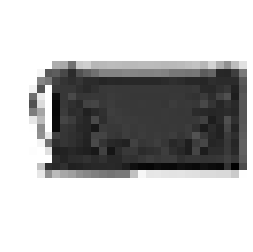

In [7]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

some_digit = X_train[36001]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap = matplotlib.cm.binary, interpolation="nearest")
plt.axis("off");

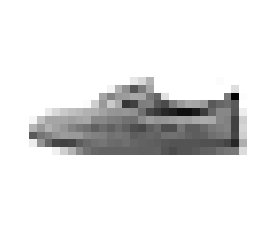

In [8]:
plot_digit(X_train[40000])

In [9]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")

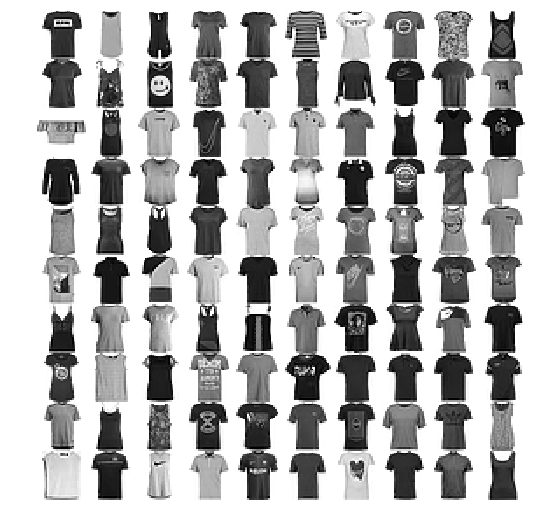

In [10]:
plt.figure(figsize=(9,9))
X_0 = X_train[(y_train == 0)]
example_images = X_0[:100]
plot_digits(example_images, images_per_row=10)

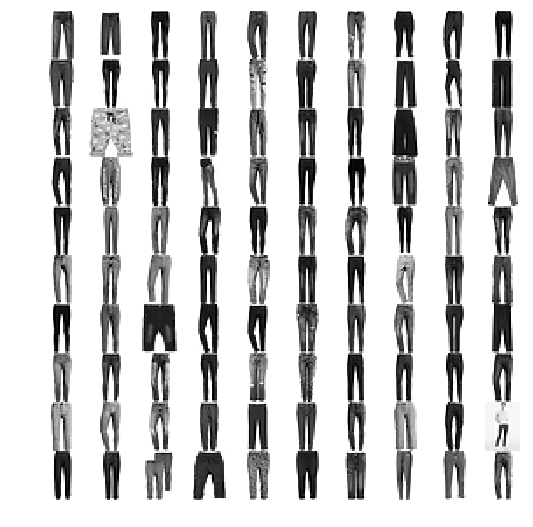

In [11]:
plt.figure(figsize=(9,9))
X_1 = X_train[(y_train == 1)]
example_images = X_1[:100]
plot_digits(example_images, images_per_row=10)

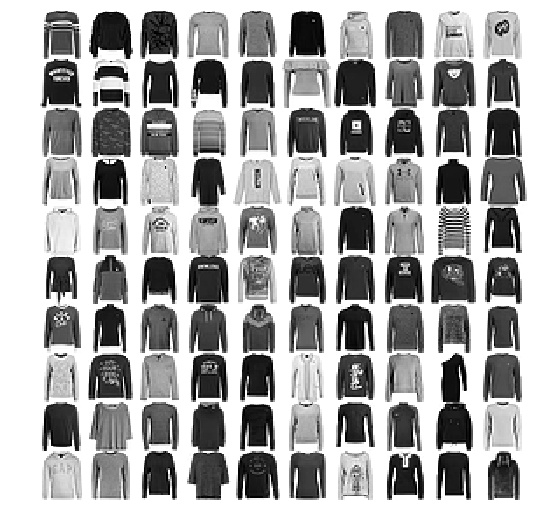

In [12]:
plt.figure(figsize=(9,9))
X_2 = X_train[(y_train == 2)]
example_images = X_2[:100]
plot_digits(example_images, images_per_row=10)

## Split Train into Train and Validate

I will split the training set into train and validate. This way, I'll know that I'm getting a proper score. 


To do this I will use a stratified sample.

I'm going to normalize this data as well.


In [13]:
seed_val = 42
from sklearn.model_selection import StratifiedShuffleSplit as SSS
from sklearn.preprocessing import Normalizer

#Normalize with default (l2) norm.
temp_N = Normalizer()
X_train_norm = temp_N.fit_transform(X_train)
X_test_norm = temp_N.fit_transform(X_test)
del temp_N

#Split 
splitter = SSS(n_splits=10, test_size=10000, random_state=seed_val)

#Build pre_train and test
for X_p_t_index, X_val_ind in splitter.split(X_train, y_train):
    X_mini_train, X_val = X_train[X_p_t_index], X_train[X_val_ind]
    X_mini_train_norm, X_val_norm = X_train_norm[X_p_t_index], X_train_norm[X_val_ind]
    y_mini_train, y_val = y_train[X_p_t_index], y_train[X_val_ind]
    


In [14]:
print(validateOccuranceOfClasses(y_mini_train))
print(validateOccuranceOfClasses(y_val))
print(len(y_val))
print(len(X_val_norm))

[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
10000
10000


## Using a built in Estimator API to make an Estimator 

In [15]:
import tensorflow as tf

In [16]:
#Input funcs 
from tensorflow.estimator.inputs import numpy_input_fn as npif
datasets = [(X_mini_train_norm, y_mini_train),(X_mini_train, y_mini_train),(X_val, y_val)]
input_fn_set = [npif(x={"darknessVal": ds_x}, 
                     y=ds_y.astype(np.int32), 
                     num_epochs=40, 
                     batch_size=50, 
                     shuffle=True) for ds_x, ds_y in datasets]

### What to do about testing diffrent amounts of neurons per layer: 

1) We were asked to try several diffrent amounts of hidden units. Before I deal with that I want to figure out if normalizing is any good. To that effect I'll train and then use the network with normalized and regular data. I'll go on with whatever one works best. 

2) After that I'll make a few input vals for the hidden_units param and see what happens when I train and evaluate. 

In [17]:
#I was originally just going to use the code from the book, 
#but that was throwing some insane warnings about deprication.
#As a result I read the docs and did it how it was discribed there.  

#1
import tensorflow.feature_column as fc 
from tensorflow.estimator import DNNClassifier as DNNC

dV_in = fc.numeric_column(key="darknessVal", shape=(28*28,))
dnn_cls = DNNC(hidden_units=[5, 1], 
               n_classes=len(validateOccuranceOfClasses(y_val)),
               feature_columns=[dV_in])

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpm1tvoup5', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fc701065e10>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [18]:
dnn_cls.train(input_fn_set[0])

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpm1tvoup5/model.ckpt.
INFO:tensorflow:loss = 115.12644, step = 1
INFO:tensorflow:global_step/sec: 535.141
INFO:tensorflow:loss = 100.20594, step = 101 (0.188 sec)
INFO:tensorflow:global_step/sec: 672.816
INFO:tensorflow:loss = 92.72798, step = 201 (0.148 sec)
INFO:tensorflow:global_step/sec: 703.834
INFO:tensorflow:loss = 89.04529, step = 301 (0.142 sec)
INFO:tensorflow:global_step/sec: 671.929
INFO:tensorflow:loss = 90.00431, step = 401 (0.149 sec)
INFO:tensorflow:global_step/sec: 623.698
INFO:tensorflow:loss = 89.47955, step = 501 (0.160 sec)
INFO:tensorflow:global_step/sec: 617.013
INFO:tensorflow:loss = 85.168945, step = 601 (0.162 sec)
INFO:tensorflow:global_step/sec: 651.155
INFO:tensorflow:loss

INFO:tensorflow:loss = 64.46866, step = 8101 (0.144 sec)
INFO:tensorflow:global_step/sec: 632.829
INFO:tensorflow:loss = 65.55701, step = 8201 (0.158 sec)
INFO:tensorflow:global_step/sec: 638.233
INFO:tensorflow:loss = 64.6839, step = 8301 (0.157 sec)
INFO:tensorflow:global_step/sec: 627.186
INFO:tensorflow:loss = 64.34306, step = 8401 (0.161 sec)
INFO:tensorflow:global_step/sec: 639.217
INFO:tensorflow:loss = 63.809643, step = 8501 (0.156 sec)
INFO:tensorflow:global_step/sec: 708.546
INFO:tensorflow:loss = 66.9954, step = 8601 (0.141 sec)
INFO:tensorflow:global_step/sec: 689.267
INFO:tensorflow:loss = 66.687675, step = 8701 (0.145 sec)
INFO:tensorflow:global_step/sec: 644.516
INFO:tensorflow:loss = 67.38355, step = 8801 (0.156 sec)
INFO:tensorflow:global_step/sec: 677.802
INFO:tensorflow:loss = 65.92432, step = 8901 (0.147 sec)
INFO:tensorflow:global_step/sec: 559.563
INFO:tensorflow:loss = 63.53481, step = 9001 (0.179 sec)
INFO:tensorflow:global_step/sec: 628.943
INFO:tensorflow:loss

INFO:tensorflow:loss = 64.65077, step = 16401 (0.140 sec)
INFO:tensorflow:global_step/sec: 707.008
INFO:tensorflow:loss = 55.96303, step = 16501 (0.142 sec)
INFO:tensorflow:global_step/sec: 713.743
INFO:tensorflow:loss = 62.563652, step = 16601 (0.140 sec)
INFO:tensorflow:global_step/sec: 652.736
INFO:tensorflow:loss = 57.37314, step = 16701 (0.154 sec)
INFO:tensorflow:global_step/sec: 692.544
INFO:tensorflow:loss = 62.8951, step = 16801 (0.144 sec)
INFO:tensorflow:global_step/sec: 704.624
INFO:tensorflow:loss = 69.76371, step = 16901 (0.142 sec)
INFO:tensorflow:global_step/sec: 671.764
INFO:tensorflow:loss = 60.337784, step = 17001 (0.149 sec)
INFO:tensorflow:global_step/sec: 751.795
INFO:tensorflow:loss = 61.68306, step = 17101 (0.133 sec)
INFO:tensorflow:global_step/sec: 694.407
INFO:tensorflow:loss = 67.372795, step = 17201 (0.144 sec)
INFO:tensorflow:global_step/sec: 701.369
INFO:tensorflow:loss = 70.71075, step = 17301 (0.144 sec)
INFO:tensorflow:global_step/sec: 646.504
INFO:ten

INFO:tensorflow:global_step/sec: 637.403
INFO:tensorflow:loss = 60.765366, step = 24701 (0.157 sec)
INFO:tensorflow:global_step/sec: 683.037
INFO:tensorflow:loss = 68.74674, step = 24801 (0.147 sec)
INFO:tensorflow:global_step/sec: 688.733
INFO:tensorflow:loss = 68.10783, step = 24901 (0.145 sec)
INFO:tensorflow:global_step/sec: 692.392
INFO:tensorflow:loss = 61.163425, step = 25001 (0.146 sec)
INFO:tensorflow:global_step/sec: 659.355
INFO:tensorflow:loss = 62.86794, step = 25101 (0.150 sec)
INFO:tensorflow:global_step/sec: 698.073
INFO:tensorflow:loss = 61.24147, step = 25201 (0.143 sec)
INFO:tensorflow:global_step/sec: 645.47
INFO:tensorflow:loss = 65.79558, step = 25301 (0.155 sec)
INFO:tensorflow:global_step/sec: 695.061
INFO:tensorflow:loss = 63.508553, step = 25401 (0.144 sec)
INFO:tensorflow:global_step/sec: 687.184
INFO:tensorflow:loss = 63.447655, step = 25501 (0.146 sec)
INFO:tensorflow:global_step/sec: 637.517
INFO:tensorflow:loss = 66.64786, step = 25601 (0.157 sec)
INFO:te

INFO:tensorflow:global_step/sec: 660.442
INFO:tensorflow:loss = 59.397877, step = 33001 (0.152 sec)
INFO:tensorflow:global_step/sec: 720.359
INFO:tensorflow:loss = 58.962547, step = 33101 (0.138 sec)
INFO:tensorflow:global_step/sec: 645.23
INFO:tensorflow:loss = 57.806408, step = 33201 (0.159 sec)
INFO:tensorflow:global_step/sec: 580.106
INFO:tensorflow:loss = 65.99464, step = 33301 (0.169 sec)
INFO:tensorflow:global_step/sec: 726.42
INFO:tensorflow:loss = 60.51592, step = 33401 (0.138 sec)
INFO:tensorflow:global_step/sec: 714.323
INFO:tensorflow:loss = 59.686108, step = 33501 (0.141 sec)
INFO:tensorflow:global_step/sec: 665.336
INFO:tensorflow:loss = 61.635532, step = 33601 (0.150 sec)
INFO:tensorflow:global_step/sec: 679.871
INFO:tensorflow:loss = 60.62662, step = 33701 (0.147 sec)
INFO:tensorflow:global_step/sec: 686.705
INFO:tensorflow:loss = 59.414097, step = 33801 (0.148 sec)
INFO:tensorflow:global_step/sec: 646.214
INFO:tensorflow:loss = 62.485466, step = 33901 (0.152 sec)
INFO:

In [19]:
from sklearn.metrics import accuracy_score as AS
p_gen = dnn_cls.predict(npif(x={"darknessVal": X_val_norm}, 
                     y=y_val.astype(np.int32), 
                     shuffle=False))

In [20]:
y_pred = list(p_gen)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpm1tvoup5/model.ckpt-40000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [21]:
[int(x['classes']) for x in y_pred]

[9,
 8,
 9,
 8,
 9,
 4,
 9,
 9,
 9,
 1,
 1,
 4,
 6,
 8,
 9,
 3,
 6,
 9,
 9,
 8,
 9,
 6,
 9,
 4,
 0,
 6,
 1,
 9,
 3,
 1,
 9,
 9,
 6,
 0,
 9,
 4,
 1,
 6,
 0,
 9,
 6,
 6,
 8,
 9,
 9,
 6,
 4,
 0,
 1,
 9,
 9,
 1,
 0,
 1,
 8,
 9,
 0,
 3,
 1,
 6,
 0,
 6,
 1,
 4,
 9,
 8,
 9,
 6,
 5,
 1,
 9,
 9,
 9,
 4,
 4,
 1,
 4,
 8,
 0,
 9,
 4,
 1,
 1,
 1,
 6,
 9,
 9,
 9,
 1,
 9,
 0,
 6,
 9,
 6,
 6,
 0,
 8,
 3,
 9,
 8,
 1,
 1,
 8,
 9,
 3,
 8,
 1,
 6,
 9,
 9,
 8,
 1,
 3,
 0,
 8,
 9,
 4,
 8,
 8,
 8,
 0,
 9,
 1,
 8,
 0,
 0,
 8,
 9,
 6,
 3,
 4,
 3,
 1,
 8,
 6,
 9,
 6,
 0,
 4,
 1,
 9,
 4,
 0,
 1,
 3,
 4,
 0,
 1,
 9,
 9,
 6,
 6,
 6,
 8,
 1,
 4,
 0,
 9,
 9,
 6,
 3,
 1,
 9,
 6,
 9,
 9,
 9,
 6,
 9,
 9,
 1,
 9,
 3,
 9,
 9,
 0,
 6,
 4,
 9,
 9,
 9,
 1,
 0,
 9,
 4,
 4,
 0,
 4,
 8,
 4,
 8,
 3,
 4,
 9,
 4,
 9,
 6,
 3,
 4,
 4,
 0,
 6,
 1,
 0,
 9,
 9,
 0,
 6,
 6,
 8,
 9,
 4,
 3,
 6,
 1,
 0,
 9,
 8,
 6,
 6,
 9,
 6,
 9,
 0,
 9,
 9,
 1,
 8,
 9,
 6,
 9,
 9,
 9,
 4,
 1,
 9,
 0,
 9,
 9,
 6,
 8,
 1,
 6,
 6,
 9,
 1,
 8,
 4,
 0,
 6,


In [22]:
AS(y_val, [int(x['classes']) for x in y_pred])

0.4806

This is a really horrible score. 

Granted I only used a total of 6 nodes. I'll increase that value to see what happens. 

In [23]:
dnn_cls_plus_n = DNNC(hidden_units=[128, 256, 512], 
               n_classes=len(validateOccuranceOfClasses(y_val)),
               feature_columns=[dV_in])

dnn_cls_plus_n.train(input_fn_set[0])

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpjdm0uybl', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fc7001a06a0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpjdm0uybl/model.ckpt.
INFO:ten

INFO:tensorflow:global_step/sec: 176.326
INFO:tensorflow:loss = 11.249846, step = 7301 (0.567 sec)
INFO:tensorflow:global_step/sec: 197.325
INFO:tensorflow:loss = 13.92276, step = 7401 (0.507 sec)
INFO:tensorflow:global_step/sec: 166.543
INFO:tensorflow:loss = 16.276373, step = 7501 (0.600 sec)
INFO:tensorflow:global_step/sec: 177.747
INFO:tensorflow:loss = 16.975857, step = 7601 (0.563 sec)
INFO:tensorflow:global_step/sec: 188.864
INFO:tensorflow:loss = 13.786543, step = 7701 (0.529 sec)
INFO:tensorflow:global_step/sec: 195.658
INFO:tensorflow:loss = 14.912953, step = 7801 (0.511 sec)
INFO:tensorflow:global_step/sec: 170.261
INFO:tensorflow:loss = 13.5775795, step = 7901 (0.587 sec)
INFO:tensorflow:global_step/sec: 195.873
INFO:tensorflow:loss = 8.605977, step = 8001 (0.511 sec)
INFO:tensorflow:global_step/sec: 188.514
INFO:tensorflow:loss = 11.022792, step = 8101 (0.530 sec)
INFO:tensorflow:global_step/sec: 190.396
INFO:tensorflow:loss = 8.670569, step = 8201 (0.527 sec)
INFO:tensorf

INFO:tensorflow:global_step/sec: 186.577
INFO:tensorflow:loss = 16.026386, step = 15601 (0.536 sec)
INFO:tensorflow:global_step/sec: 198.317
INFO:tensorflow:loss = 8.471373, step = 15701 (0.504 sec)
INFO:tensorflow:global_step/sec: 187.513
INFO:tensorflow:loss = 7.3604717, step = 15801 (0.534 sec)
INFO:tensorflow:global_step/sec: 196.243
INFO:tensorflow:loss = 4.421281, step = 15901 (0.510 sec)
INFO:tensorflow:global_step/sec: 178.099
INFO:tensorflow:loss = 6.090969, step = 16001 (0.561 sec)
INFO:tensorflow:global_step/sec: 186.207
INFO:tensorflow:loss = 19.575253, step = 16101 (0.539 sec)
INFO:tensorflow:global_step/sec: 167.657
INFO:tensorflow:loss = 15.258926, step = 16201 (0.595 sec)
INFO:tensorflow:global_step/sec: 167.326
INFO:tensorflow:loss = 13.92819, step = 16301 (0.597 sec)
INFO:tensorflow:global_step/sec: 161.589
INFO:tensorflow:loss = 9.412085, step = 16401 (0.620 sec)
INFO:tensorflow:global_step/sec: 179.776
INFO:tensorflow:loss = 14.317332, step = 16501 (0.557 sec)
INFO:

INFO:tensorflow:global_step/sec: 204.314
INFO:tensorflow:loss = 13.567536, step = 23901 (0.490 sec)
INFO:tensorflow:global_step/sec: 190
INFO:tensorflow:loss = 9.441158, step = 24001 (0.528 sec)
INFO:tensorflow:global_step/sec: 202.175
INFO:tensorflow:loss = 11.520059, step = 24101 (0.493 sec)
INFO:tensorflow:global_step/sec: 184.634
INFO:tensorflow:loss = 14.650337, step = 24201 (0.543 sec)
INFO:tensorflow:global_step/sec: 199.518
INFO:tensorflow:loss = 14.16898, step = 24301 (0.500 sec)
INFO:tensorflow:global_step/sec: 193.68
INFO:tensorflow:loss = 22.59049, step = 24401 (0.516 sec)
INFO:tensorflow:global_step/sec: 197.468
INFO:tensorflow:loss = 7.6143274, step = 24501 (0.507 sec)
INFO:tensorflow:global_step/sec: 183.277
INFO:tensorflow:loss = 10.351903, step = 24601 (0.545 sec)
INFO:tensorflow:global_step/sec: 200.236
INFO:tensorflow:loss = 6.1053853, step = 24701 (0.499 sec)
INFO:tensorflow:global_step/sec: 185.756
INFO:tensorflow:loss = 8.875977, step = 24801 (0.538 sec)
INFO:tens

INFO:tensorflow:global_step/sec: 178.372
INFO:tensorflow:loss = 7.8607635, step = 32201 (0.561 sec)
INFO:tensorflow:global_step/sec: 174.164
INFO:tensorflow:loss = 6.5284734, step = 32301 (0.572 sec)
INFO:tensorflow:global_step/sec: 177.451
INFO:tensorflow:loss = 11.147017, step = 32401 (0.564 sec)
INFO:tensorflow:global_step/sec: 170.114
INFO:tensorflow:loss = 8.933001, step = 32501 (0.588 sec)
INFO:tensorflow:global_step/sec: 176.492
INFO:tensorflow:loss = 5.7133017, step = 32601 (0.566 sec)
INFO:tensorflow:global_step/sec: 176.492
INFO:tensorflow:loss = 6.4891953, step = 32701 (0.567 sec)
INFO:tensorflow:global_step/sec: 189.654
INFO:tensorflow:loss = 7.793868, step = 32801 (0.527 sec)
INFO:tensorflow:global_step/sec: 168.282
INFO:tensorflow:loss = 3.8075325, step = 32901 (0.594 sec)
INFO:tensorflow:global_step/sec: 178.688
INFO:tensorflow:loss = 4.579686, step = 33001 (0.560 sec)
INFO:tensorflow:global_step/sec: 176.775
INFO:tensorflow:loss = 2.2438498, step = 33101 (0.566 sec)
INF

In [24]:
p_gen_plus_n = dnn_cls_plus_n.predict(npif(x={"darknessVal": X_val_norm}, 
                     y=y_val.astype(np.int32), 
                     shuffle=False))

In [25]:
y_pred_plus_n = list(p_gen_plus_n)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpjdm0uybl/model.ckpt-40000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [26]:
AS(y_val, [int(x['classes']) for x in y_pred_plus_n])

0.8876

This is a MUCH better score. It's clear that more nodes results in much better preformance. 

In [27]:
dnn_cls_non_normal_train = DNNC(hidden_units=[128, 256, 512], 
               n_classes=len(validateOccuranceOfClasses(y_val)),
               feature_columns=[dV_in])

dnn_cls_non_normal_train.train(input_fn_set[1])

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmp2wkav9pj', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fc754436358>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmp2wkav9pj/model.ckpt.
INFO:ten

INFO:tensorflow:loss = 62.871994, step = 7301 (0.559 sec)
INFO:tensorflow:global_step/sec: 177.638
INFO:tensorflow:loss = 67.647804, step = 7401 (0.563 sec)
INFO:tensorflow:global_step/sec: 176.806
INFO:tensorflow:loss = 62.935356, step = 7501 (0.566 sec)
INFO:tensorflow:global_step/sec: 190.628
INFO:tensorflow:loss = 61.5789, step = 7601 (0.525 sec)
INFO:tensorflow:global_step/sec: 181.446
INFO:tensorflow:loss = 68.45238, step = 7701 (0.551 sec)
INFO:tensorflow:global_step/sec: 184.765
INFO:tensorflow:loss = 62.2823, step = 7801 (0.541 sec)
INFO:tensorflow:global_step/sec: 188.071
INFO:tensorflow:loss = 57.073494, step = 7901 (0.533 sec)
INFO:tensorflow:global_step/sec: 182.238
INFO:tensorflow:loss = 69.19937, step = 8001 (0.547 sec)
INFO:tensorflow:global_step/sec: 183.717
INFO:tensorflow:loss = 59.685295, step = 8101 (0.544 sec)
INFO:tensorflow:global_step/sec: 181.11
INFO:tensorflow:loss = 65.8056, step = 8201 (0.552 sec)
INFO:tensorflow:global_step/sec: 178.928
INFO:tensorflow:los

INFO:tensorflow:loss = 29.638992, step = 15601 (0.538 sec)
INFO:tensorflow:global_step/sec: 187.348
INFO:tensorflow:loss = 30.648932, step = 15701 (0.535 sec)
INFO:tensorflow:global_step/sec: 186.46
INFO:tensorflow:loss = 35.636314, step = 15801 (0.535 sec)
INFO:tensorflow:global_step/sec: 192.036
INFO:tensorflow:loss = 35.605225, step = 15901 (0.522 sec)
INFO:tensorflow:global_step/sec: 190.912
INFO:tensorflow:loss = 38.724724, step = 16001 (0.523 sec)
INFO:tensorflow:global_step/sec: 181.97
INFO:tensorflow:loss = 40.120495, step = 16101 (0.551 sec)
INFO:tensorflow:global_step/sec: 177.921
INFO:tensorflow:loss = 40.64303, step = 16201 (0.561 sec)
INFO:tensorflow:global_step/sec: 179.651
INFO:tensorflow:loss = 25.791992, step = 16301 (0.556 sec)
INFO:tensorflow:global_step/sec: 182.692
INFO:tensorflow:loss = 26.405151, step = 16401 (0.547 sec)
INFO:tensorflow:global_step/sec: 187.717
INFO:tensorflow:loss = 32.101006, step = 16501 (0.533 sec)
INFO:tensorflow:global_step/sec: 184
INFO:te

INFO:tensorflow:global_step/sec: 182.793
INFO:tensorflow:loss = 33.041695, step = 23901 (0.547 sec)
INFO:tensorflow:global_step/sec: 178.186
INFO:tensorflow:loss = 32.6131, step = 24001 (0.561 sec)
INFO:tensorflow:global_step/sec: 188.784
INFO:tensorflow:loss = 26.328583, step = 24101 (0.530 sec)
INFO:tensorflow:global_step/sec: 184.389
INFO:tensorflow:loss = 22.888767, step = 24201 (0.543 sec)
INFO:tensorflow:global_step/sec: 185.839
INFO:tensorflow:loss = 30.28303, step = 24301 (0.540 sec)
INFO:tensorflow:global_step/sec: 180.737
INFO:tensorflow:loss = 30.410025, step = 24401 (0.552 sec)
INFO:tensorflow:global_step/sec: 182.378
INFO:tensorflow:loss = 33.151833, step = 24501 (0.549 sec)
INFO:tensorflow:global_step/sec: 184.39
INFO:tensorflow:loss = 24.69896, step = 24601 (0.541 sec)
INFO:tensorflow:global_step/sec: 189.233
INFO:tensorflow:loss = 27.044472, step = 24701 (0.528 sec)
INFO:tensorflow:global_step/sec: 189.032
INFO:tensorflow:loss = 21.841137, step = 24801 (0.529 sec)
INFO:

INFO:tensorflow:loss = 36.136402, step = 32101 (0.536 sec)
INFO:tensorflow:global_step/sec: 194.781
INFO:tensorflow:loss = 25.845045, step = 32201 (0.513 sec)
INFO:tensorflow:global_step/sec: 181.278
INFO:tensorflow:loss = 30.429432, step = 32301 (0.552 sec)
INFO:tensorflow:global_step/sec: 184.387
INFO:tensorflow:loss = 25.45125, step = 32401 (0.543 sec)
INFO:tensorflow:global_step/sec: 187.818
INFO:tensorflow:loss = 29.286161, step = 32501 (0.532 sec)
INFO:tensorflow:global_step/sec: 185.258
INFO:tensorflow:loss = 35.018593, step = 32601 (0.541 sec)
INFO:tensorflow:global_step/sec: 177.536
INFO:tensorflow:loss = 25.001104, step = 32701 (0.562 sec)
INFO:tensorflow:global_step/sec: 187.753
INFO:tensorflow:loss = 28.176638, step = 32801 (0.532 sec)
INFO:tensorflow:global_step/sec: 185.617
INFO:tensorflow:loss = 30.638525, step = 32901 (0.538 sec)
INFO:tensorflow:global_step/sec: 186.026
INFO:tensorflow:loss = 24.756498, step = 33001 (0.538 sec)
INFO:tensorflow:global_step/sec: 190.979
I

In [ ]:
p_gen_non_normal = dnn_cls_plus_n.predict(npif(x={"darknessVal": X_val}, 
                     y=y_val.astype(np.int32), 
                     shuffle=False))


In [138]:
AS(y_val, [int(x['classes']) for x in [v for v in p_gen_non_normal]])

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpiptzuowq/model.ckpt-40000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


0.4942

It seems that normalizing improves preformance. I don't really understand why because in theory the weights of the nodes within our net should compensate for unnormalized data. This could mean that maybe we'd need more nodes or data to see the same performance if we don't normalize. 

Or I just made a mistake with my code. But I don't think that's the case here. 

Now I'll clean up the workspace a bit: 

In [143]:
try:
    p_gen_non_normal
except NameError:
    pass
else:
    del p_gen_non_normal

try:
    dnn_cls_non_normal_train
except NameError:
    pass
else:
    del dnn_cls_non_normal_train

try:
    X_train
except NameError:
    pass
else:
    del X_train
    
try:
    X_test
except NameError:
    pass
else:
    del X_test

In [145]:
X_train_norm

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

# DNN with plain tensorflow 

I'm basically copying the code from class and the book. I will be using the normalized dataset though, in hopes that we get a decent result. 

In [165]:
def shuffle_batch(X, y, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        yield X_batch, y_batch

n_inputs = 28*28  # MNIST
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10

In [166]:
reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y") 

In [167]:
with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, name="hidden1",
                              activation=tf.nn.relu)
    hidden2 = tf.layers.dense(hidden1, n_hidden2, name="hidden2",
                              activation=tf.nn.relu)
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")
    y_proba = tf.nn.softmax(logits)

In [171]:
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()
saver = tf.train.Saver()

n_epochs = 20
n_batches = 50

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train_norm, y_train, 50):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_batch = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_valid = accuracy.eval(feed_dict={X: X_val_norm, y: y_val})
        print(epoch, "Batch accuracy:", acc_batch, "Validation accuracy:", acc_valid)

    save_path = saver.save(sess, "./my_model_final.ckpt")

0 Batch accuracy: 0.48 Validation accuracy: 0.4717
1 Batch accuracy: 0.62 Validation accuracy: 0.6197
2 Batch accuracy: 0.66 Validation accuracy: 0.6784
3 Batch accuracy: 0.7 Validation accuracy: 0.7241
4 Batch accuracy: 0.8 Validation accuracy: 0.7455
5 Batch accuracy: 0.86 Validation accuracy: 0.7603
6 Batch accuracy: 0.8 Validation accuracy: 0.7691
7 Batch accuracy: 0.8 Validation accuracy: 0.7793
8 Batch accuracy: 0.72 Validation accuracy: 0.7895
9 Batch accuracy: 0.88 Validation accuracy: 0.7951
10 Batch accuracy: 0.76 Validation accuracy: 0.7965
11 Batch accuracy: 0.9 Validation accuracy: 0.8045
12 Batch accuracy: 0.76 Validation accuracy: 0.8073
13 Batch accuracy: 0.82 Validation accuracy: 0.8141
14 Batch accuracy: 0.8 Validation accuracy: 0.816
15 Batch accuracy: 0.84 Validation accuracy: 0.8177
16 Batch accuracy: 0.86 Validation accuracy: 0.8221
17 Batch accuracy: 0.84 Validation accuracy: 0.8249
18 Batch accuracy: 0.82 Validation accuracy: 0.8262
19 Batch accuracy: 0.76 Valid

It seems that this version of the alogrithm preformed a bit worse than the built in estimator. I assume that this would be due to the fact that the our optimizer is just the standard Gradient Decent optimizer, whereas I used a diffrent one with the built in API. 

I know that we talked about the momentum optimizer and how that is also supposed to out-preform gradient decent. 

## PCA to speed up training 

I'll use PCA here. 

My assumption is that we'll see a serious speed increase in the training. At the moment it's pretty slow, even with mini-batch. 

I think the speed increase will be great due to the fact that we have a lot of data that's just 0s (AKA unused dimensions). (Any place were we have a white px). This means that we should be able to reduce the demensionality by a whole lot, while keeping most of the variance in our data. 

In [178]:
from sklearn.decomposition import PCA

reducer = PCA(n_components=.95)
X_train_norm_reduced = reducer.fit_transform(X_train_norm)
X_test_norm_reduced = reducer.transform(X_test_norm)

In [179]:
print(X_train_norm_reduced.shape)
print(X_test_norm_reduced.shape)

(60000, 256)
(10000, 256)


In [181]:
dV_in_DR = fc.numeric_column(key="darknessVal", shape=(X_train_norm_reduced.shape[1],))

dnn_cls_DR = DNNC(hidden_units=[128, 256, 512], 
               n_classes=len(validateOccuranceOfClasses(y_val)),
               feature_columns=[dV_in_DR])

input_fn_DR_train = npif(x={"darknessVal": X_train_norm_reduced}, 
                     y=y_train.astype(np.int32), 
                     num_epochs=40, 
                     batch_size=50, 
                     shuffle=True)

input_fn_DR_test = npif(x={"darknessVal": X_test_norm_reduced}, 
                     y=y_test.astype(np.int32), 
                     shuffle=False)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmp9g4tvyfn', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f5bc44ed2b0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [182]:
dnn_cls_DR.train(input_fn_DR_train)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmp9g4tvyfn/model.ckpt.
INFO:tensorflow:loss = 115.40721, step = 1
INFO:tensorflow:global_step/sec: 106.942
INFO:tensorflow:loss = 28.688124, step = 101 (0.936 sec)
INFO:tensorflow:global_step/sec: 108.697
INFO:tensorflow:loss = 21.528978, step = 201 (0.920 sec)
INFO:tensorflow:global_step/sec: 114.442
INFO:tensorflow:loss = 25.129671, step = 301 (0.874 sec)
INFO:tensorflow:global_step/sec: 160.582
INFO:tensorflow:loss = 13.043201, step = 401 (0.623 sec)
INFO:tensorflow:global_step/sec: 98.5258
INFO:tensorflow:loss = 15.827673, step = 501 (1.036 sec)
INFO:tensorflow:global_step/sec: 127.924
INFO:tensorflow:loss = 28.687029, step = 601 (0.764 sec)
INFO:tensorflow:global_step/sec: 108.526
INFO:tensorflow:

INFO:tensorflow:global_step/sec: 104.137
INFO:tensorflow:loss = 13.785872, step = 8101 (0.959 sec)
INFO:tensorflow:global_step/sec: 123.09
INFO:tensorflow:loss = 8.094595, step = 8201 (0.809 sec)
INFO:tensorflow:global_step/sec: 99.117
INFO:tensorflow:loss = 6.417336, step = 8301 (1.010 sec)
INFO:tensorflow:global_step/sec: 126.186
INFO:tensorflow:loss = 4.5117154, step = 8401 (0.797 sec)
INFO:tensorflow:global_step/sec: 93.5238
INFO:tensorflow:loss = 11.0855665, step = 8501 (1.070 sec)
INFO:tensorflow:global_step/sec: 113.711
INFO:tensorflow:loss = 11.868248, step = 8601 (0.890 sec)
INFO:tensorflow:global_step/sec: 90.1295
INFO:tensorflow:loss = 18.370953, step = 8701 (1.109 sec)
INFO:tensorflow:global_step/sec: 125.493
INFO:tensorflow:loss = 10.745783, step = 8801 (0.781 sec)
INFO:tensorflow:global_step/sec: 100.993
INFO:tensorflow:loss = 8.084882, step = 8901 (1.006 sec)
INFO:tensorflow:global_step/sec: 74.8066
INFO:tensorflow:loss = 7.544739, step = 9001 (1.325 sec)
INFO:tensorflow

INFO:tensorflow:global_step/sec: 123.071
INFO:tensorflow:loss = 7.172062, step = 16401 (0.811 sec)
INFO:tensorflow:global_step/sec: 96.4485
INFO:tensorflow:loss = 2.1890075, step = 16501 (1.037 sec)
INFO:tensorflow:global_step/sec: 119.025
INFO:tensorflow:loss = 1.4051456, step = 16601 (0.842 sec)
INFO:tensorflow:global_step/sec: 84.5411
INFO:tensorflow:loss = 2.6620617, step = 16701 (1.180 sec)
INFO:tensorflow:global_step/sec: 110.648
INFO:tensorflow:loss = 1.745597, step = 16801 (0.904 sec)
INFO:tensorflow:global_step/sec: 94.805
INFO:tensorflow:loss = 3.0311844, step = 16901 (1.055 sec)
INFO:tensorflow:global_step/sec: 119.219
INFO:tensorflow:loss = 5.656349, step = 17001 (0.839 sec)
INFO:tensorflow:global_step/sec: 94.9646
INFO:tensorflow:loss = 9.968422, step = 17101 (1.053 sec)
INFO:tensorflow:global_step/sec: 118.398
INFO:tensorflow:loss = 4.858425, step = 17201 (0.848 sec)
INFO:tensorflow:global_step/sec: 119.245
INFO:tensorflow:loss = 6.1460023, step = 17301 (0.836 sec)
INFO:t

INFO:tensorflow:loss = 1.0790424, step = 24601 (0.904 sec)
INFO:tensorflow:global_step/sec: 102.518
INFO:tensorflow:loss = 0.55915886, step = 24701 (0.977 sec)
INFO:tensorflow:global_step/sec: 121.181
INFO:tensorflow:loss = 4.1108985, step = 24801 (0.824 sec)
INFO:tensorflow:global_step/sec: 123.557
INFO:tensorflow:loss = 1.5521556, step = 24901 (0.809 sec)
INFO:tensorflow:global_step/sec: 74.4758
INFO:tensorflow:loss = 11.286166, step = 25001 (1.347 sec)
INFO:tensorflow:global_step/sec: 112.026
INFO:tensorflow:loss = 1.1768775, step = 25101 (0.891 sec)
INFO:tensorflow:global_step/sec: 91.5723
INFO:tensorflow:loss = 5.127057, step = 25201 (1.092 sec)
INFO:tensorflow:global_step/sec: 107.476
INFO:tensorflow:loss = 1.6742679, step = 25301 (0.932 sec)
INFO:tensorflow:global_step/sec: 74.7719
INFO:tensorflow:loss = 1.3613406, step = 25401 (1.334 sec)
INFO:tensorflow:global_step/sec: 95.2848
INFO:tensorflow:loss = 4.790599, step = 25501 (1.054 sec)
INFO:tensorflow:global_step/sec: 85.055
IN

INFO:tensorflow:loss = 0.42684853, step = 32801 (1.101 sec)
INFO:tensorflow:global_step/sec: 107.882
INFO:tensorflow:loss = 0.88361406, step = 32901 (0.928 sec)
INFO:tensorflow:global_step/sec: 90.0009
INFO:tensorflow:loss = 0.04221343, step = 33001 (1.111 sec)
INFO:tensorflow:global_step/sec: 116.548
INFO:tensorflow:loss = 0.40443933, step = 33101 (0.858 sec)
INFO:tensorflow:global_step/sec: 105.976
INFO:tensorflow:loss = 0.35789463, step = 33201 (0.944 sec)
INFO:tensorflow:global_step/sec: 120.538
INFO:tensorflow:loss = 0.26425725, step = 33301 (0.830 sec)
INFO:tensorflow:global_step/sec: 77.0082
INFO:tensorflow:loss = 2.8024616, step = 33401 (1.303 sec)
INFO:tensorflow:global_step/sec: 87.0144
INFO:tensorflow:loss = 0.39103016, step = 33501 (1.145 sec)
INFO:tensorflow:global_step/sec: 68.5282
INFO:tensorflow:loss = 3.2581768, step = 33601 (1.472 sec)
INFO:tensorflow:global_step/sec: 58.1906
INFO:tensorflow:loss = 0.9247064, step = 33701 (1.708 sec)
INFO:tensorflow:global_step/sec: 5

INFO:tensorflow:global_step/sec: 96.8598
INFO:tensorflow:loss = 0.08952578, step = 41001 (1.017 sec)
INFO:tensorflow:global_step/sec: 122.527
INFO:tensorflow:loss = 0.07836064, step = 41101 (0.817 sec)
INFO:tensorflow:global_step/sec: 96.5058
INFO:tensorflow:loss = 0.14250241, step = 41201 (1.035 sec)
INFO:tensorflow:global_step/sec: 116.405
INFO:tensorflow:loss = 0.07339869, step = 41301 (0.859 sec)
INFO:tensorflow:global_step/sec: 122.656
INFO:tensorflow:loss = 0.20378488, step = 41401 (0.818 sec)
INFO:tensorflow:global_step/sec: 94.6471
INFO:tensorflow:loss = 0.05549065, step = 41501 (1.055 sec)
INFO:tensorflow:global_step/sec: 114.821
INFO:tensorflow:loss = 0.20903496, step = 41601 (0.870 sec)
INFO:tensorflow:global_step/sec: 94.5599
INFO:tensorflow:loss = 0.09173693, step = 41701 (1.058 sec)
INFO:tensorflow:global_step/sec: 112.417
INFO:tensorflow:loss = 0.2518537, step = 41801 (0.889 sec)
INFO:tensorflow:global_step/sec: 104.489
INFO:tensorflow:loss = 0.35698867, step = 41901 (0.

In [183]:
p_gen_test_DR = dnn_cls_DR.predict(input_fn_DR_test)
AS(y_test, [int(x['classes']) for x in [v for v in p_gen_test_DR]])

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp9g4tvyfn/model.ckpt-48000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


0.8811

We did see a slight speed increase. Not as dramatic as I was expecting, but it was there none the less. 

Average time to calculate one step dropped from 1 sec to .7 seconds. This improvement didn't mean much in this case, but on larger datasets, I'm sure it could save a couple of days.

One thing that surprised me is the fact that we see practically no reduction in accuracy. (.881 vs .887)

Overall PCA seems really useful in this situation.

I was correct in my assumption that PCA reduced the number of demensions by a lot (700 to 200). 